# Trust, Failure Analysis, and Robustness in Vision Systems

In previous chapters, we used Grad-CAM to visualize what our model focuses on.

In this notebook, we go further:

1. Identify misclassifications
2. Analyze model confidence
3. Study explanation behavior
4. Demonstrate adversarial vulnerability
5. Reflect on trust and deployment risk

A high-accuracy model is not automatically a trustworthy model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# Load Model (from 10a)

model = tf.keras.models.load_model("model_registry/v1/model")


In [2]:
# Load Validation Set

IMG_SIZE = 160
BATCH_SIZE = 32

(ds_val,) = tfds.load(
    "tf_flowers",
    split=["train[80%:]"],
    as_supervised=True
)

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_val = ds_val.map(preprocess).batch(BATCH_SIZE)


In [3]:
# Collect Misclassifications

misclassified = []

for images, labels in ds_val:
    preds = model.predict(images, verbose=0)
    pred_labels = tf.argmax(preds, axis=1)
    for i in range(len(labels)):
        if pred_labels[i] != labels[i]:
            misclassified.append((images[i], labels[i], preds[i]))
    if len(misclassified) >= 20:
        break

print("Collected misclassifications:", len(misclassified))


Collected misclassifications: 22


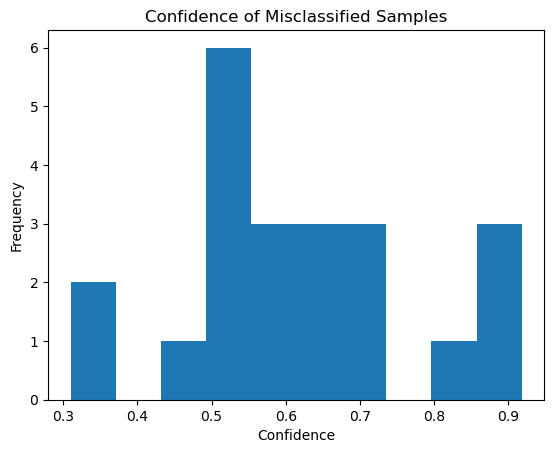

In [5]:
# Visualize Confidence

confidences = [np.max(p) for _, _, p in misclassified]

plt.hist(confidences, bins=10)
plt.title("Confidence of Misclassified Samples")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()


In [6]:
# Simple Adversarial Example (FGSM)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(image, label):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

image, label, _ = misclassified[0]
image = tf.expand_dims(image, 0)
label = tf.expand_dims(label, 0)

perturbations = create_adversarial_pattern(image, label)
epsilon = 0.02
adv_image = image + epsilon * perturbations
adv_image = tf.clip_by_value(adv_image, 0, 1)

original_pred = tf.argmax(model(image), axis=1)
adv_pred = tf.argmax(model(adv_image), axis=1)

print("Original prediction:", original_pred.numpy())
print("Adversarial prediction:", adv_pred.numpy())


Original prediction: [4]
Adversarial prediction: [4]


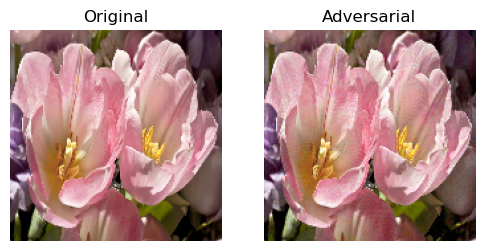

In [7]:
# Visualization

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(image[0])
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(adv_image[0])
plt.title("Adversarial")
plt.axis("off")
plt.show()


# Key Takeaways

- Misclassifications can be high confidence.
- Models are vulnerable to small perturbations.
- Accuracy alone is not sufficient for trust.
- Monitoring and explainability are part of responsible deployment.

As you move into your capstone project, think beyond: ***"Does my model work?"***

Ask instead: ***"Can I trust it in the real world?"***
